# Uplift modelling

🌵🌵🌵  
Первая часть это попытка анализа данных, манипуляции с данными и проверка трех подходов в решении задачи,   
изначально писал свое решение 🤪🤪🤪, но затем нашел библиотеку sklift     

После проверки всех линейных/нелинейных моделей, нормализации, генерации новых фич, классификатор `XGBClassifier` 
показал лучший результат, а максимальный `qini_score=0.3` 😱😱😱   
Затем я решил обучить нейронную сеть (код в конце файла) для нее максимальный результат `qini_score=0.51` 🥳🥳🥳  

https://ods.ai/competitions/megafon-df21-comp/leaderboard  


### Импортируем нужные библиотеки и предобработаем данные, а также установим random seed  ✨✨✨

In [1]:
%%time
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import random as python_random
from sklearn.model_selection import GridSearchCV
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklift.models import ClassTransformation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from pylift import TransformedOutcome
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,  train_test_split, GridSearchCV
from scipy.stats import uniform, reciprocal, t
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

plt.style.use('fivethirtyeight')

seed = 123
tf_seed = 1234

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(tf_seed)


CPU times: user 4.88 s, sys: 1.16 s, total: 6.04 s
Wall time: 5.34 s


In [2]:

TRAIN_CSV_PATH = '/Users/denismashukov/Downloads/megafon/train.csv'
TEST_CSV_PATH = '/Users/denismashukov/Downloads/megafon/test.csv'

def load_train_data():
    return pd.read_csv(TRAIN_CSV_PATH, sep=',', error_bad_lines=False, index_col=False, engine ='python')

def load_test_data():
    return pd.read_csv(TEST_CSV_PATH, sep=',', error_bad_lines=False, index_col=False, engine ='python')

df_train = load_train_data()
df_test = load_test_data()


In [3]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

df_train.rename(columns={'conversion': 'Outcome'}, inplace=True)
df_train.rename(columns={'treatment_group': 'Treatment'}, inplace=True)
df_test.rename(columns={'treatment_group': 'Treatment'}, inplace=True)

df_test.Treatment = df_test.Treatment.map({'treatment': 1, 'control': 0})
df_train.Treatment = df_train.Treatment.map({'treatment': 1, 'control': 0})


### Находим коррелирующие признаки

In [4]:
cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

['X_12', 'X_21', 'X_25', 'X_43', 'X_45', 'X_47', 'X_49']


### Посмотрим на данные 🤓🤓🤓

In [52]:
df_train.head()

,Treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,Outcome
0,0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,...,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,0,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,...,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,1,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,...,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,1,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,...,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,1,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,...,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [53]:
df_train.Outcome.value_counts()

0    477486
1    122514
Name: Outcome, dtype: int64

In [54]:
df_train[df_train['Treatment'] == 1].Outcome.value_counts()

0    231608
1     68760
Name: Outcome, dtype: int64

In [55]:
df_train[df_train['Treatment'] == 0].Outcome.value_counts()

0    245878
1     53754
Name: Outcome, dtype: int64

In [56]:
df_train.Treatment.value_counts()

1    300368
0    299632
Name: Treatment, dtype: int64

In [131]:
def target_rate(df):
    treatment_visit_rate = df[df.treatment == 1].Outcome.mean() * 100
    control_visit_rate = df[df.treatment == 0].Outcome.mean() * 100
    average_treatment_effect = treatment_visit_rate - control_visit_rate
    print("Test set target rate uplift: {:.2f}%".format(average_treatment_effect))
    return average_treatment_effect

average_treatment_effect = target_rate(df_train)

Test set target rate uplift: 4.95%


### Разделим данные на train и test  🧐
на test я выбираю лучшую моедль  
для train будем использовать kfold cross validation

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split


df_features = df_train.drop(['Outcome'], axis=1)

train_index, test_index = train_test_split(df_train.index, test_size=0.2, random_state=42)

#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
#for train_index, test_index in split.split(df_train, df_train["Treatment"]):
X_train = df_features.loc[train_index, :]
y_train = df_train.loc[train_index, 'Outcome']
treat_train = df_train.loc[train_index, 'Treatment']

X_val = df_features.loc[test_index, :]
y_val = df_train.loc[test_index, 'Outcome']
treat_val =  df_train.loc[test_index, 'Treatment']

indices_train = df_train.index
indices_test = df_test.index

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'Outcome']
treat_train_full = df_train.loc[:, 'Treatment']

X_test = df_test.copy()

cat_features = []

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [136]:
model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

model.fit(X_train, y_train)


df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)

df_feature_importance[:20]

,feature,importance
6,X_6,783
38,X_38,771
10,X_10,677
28,X_28,672
16,X_16,664
48,X_48,649
32,X_32,619
8,X_8,533
4,X_4,528
40,X_40,471


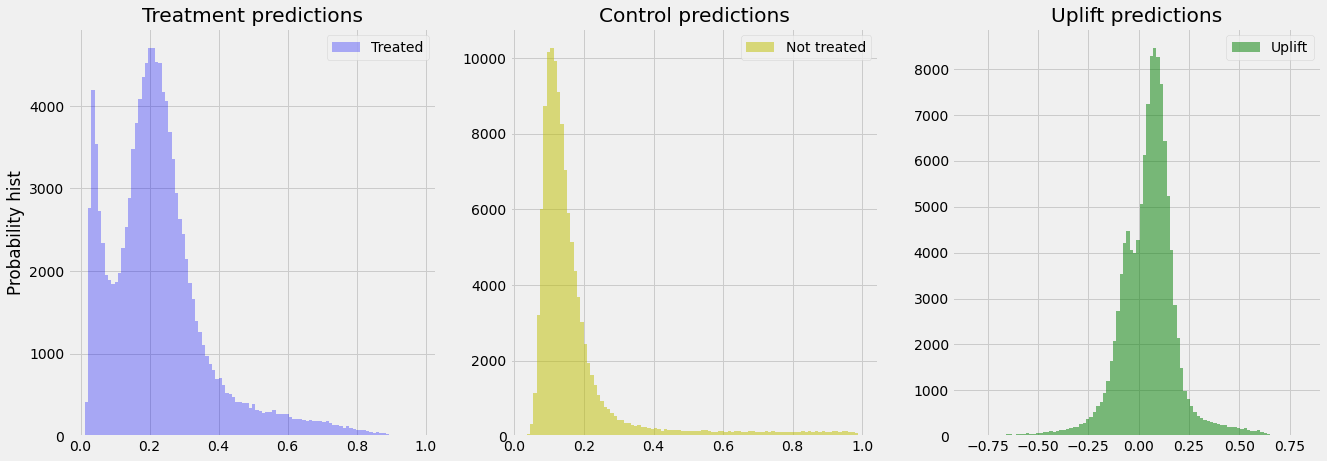

In [6]:
from sklift.models import TwoModels
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

trans = PolynomialFeatures(degree=2)
models_1 = Pipeline(steps=[('t', trans), ('m', model)])


model2 = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

trans2 = PolynomialFeatures(degree=2)
models_2 = Pipeline(steps=[('t', trans2), ('m', model2)])


tm = TwoModels(
    estimator_trmnt=model, 
    estimator_ctrl=model2, 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train.astype(int), treat_train
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val.astype(int), uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

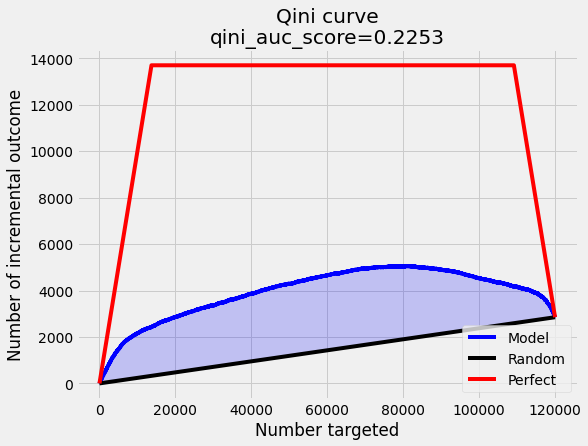

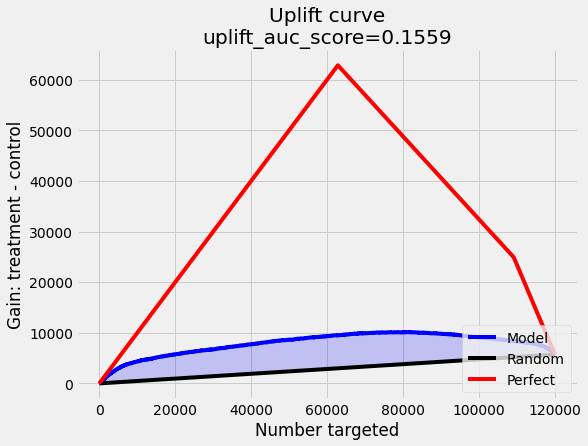

In [7]:
# import vizualisation tools
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
plot_qini_curve(y_true=y_val, uplift=uplift_tm, treatment=treat_val, negative_effect=True)

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_tm, treat_val, perfect=True);

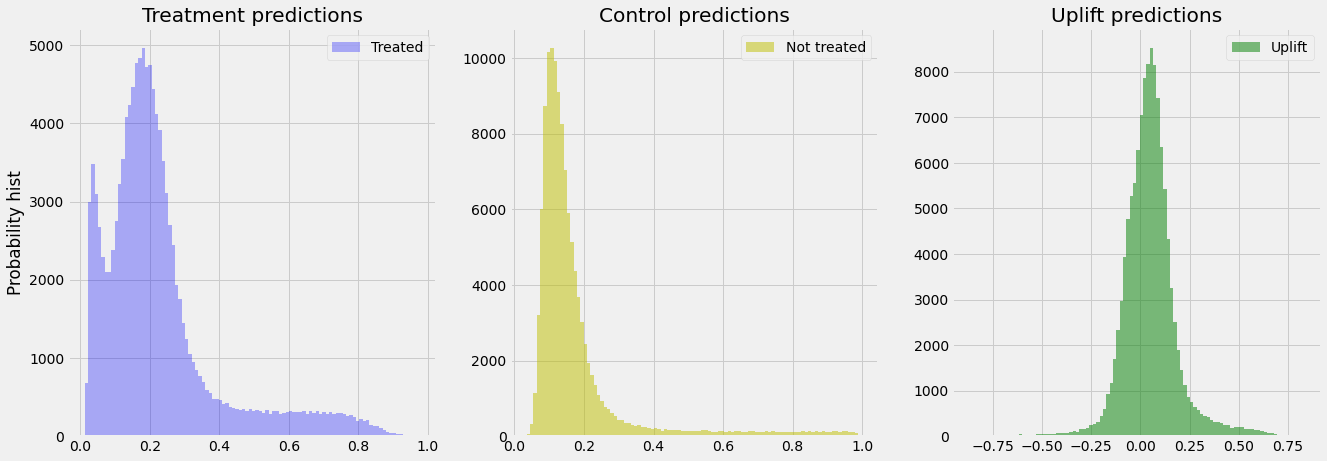

In [11]:
from sklearn.neural_network import MLPClassifier
# MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

model_1 = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

models_1 = Pipeline(steps=[('t', PolynomialFeatures(degree=2)), ('m', model_1)])

model_2 = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

models_2 = Pipeline(steps=[('t', PolynomialFeatures(degree=2)), ('m', model_2)])


tm_ctrl = TwoModels(
    estimator_trmnt=model_1, 
    estimator_ctrl=model_2, 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

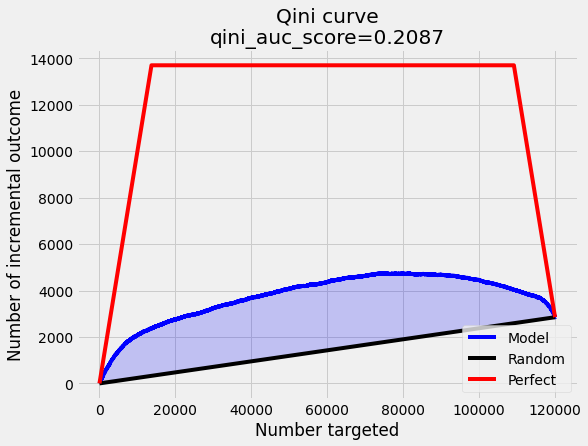

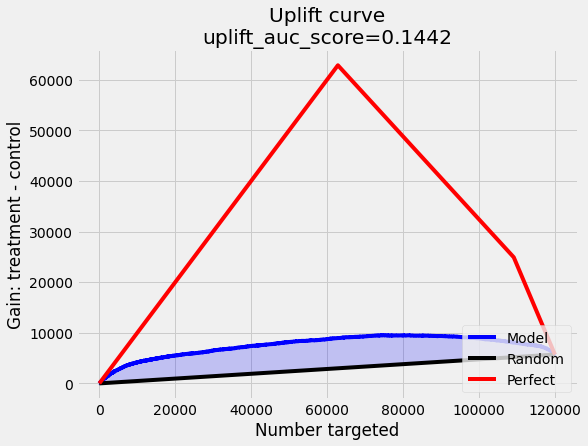

In [12]:
# import vizualisation tools
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
plot_qini_curve(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, negative_effect=True)

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_tm_ctrl, treat_val, perfect=True);

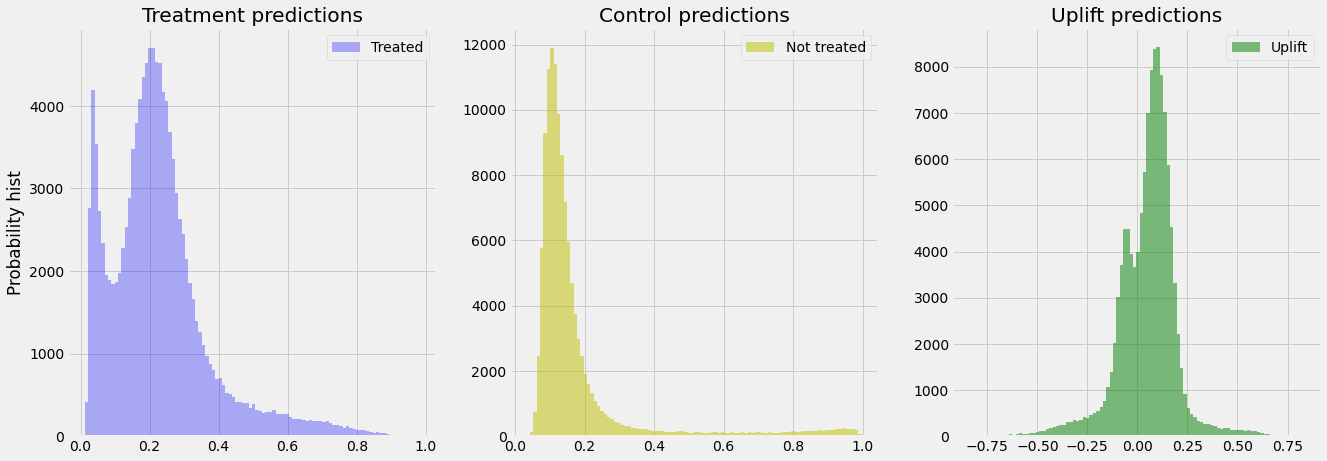

In [15]:
tm_trmnt = TwoModels(
    estimator_trmnt=lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40), 
    estimator_ctrl=lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40), 
    method='ddr_treatment'
)
tm_trmnt = tm_trmnt.fit(
    X_train, y_train, treat_train
)

uplift_tm_trmnt = tm_trmnt.predict(X_val)

tm_trmnt_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_trmnt_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_);

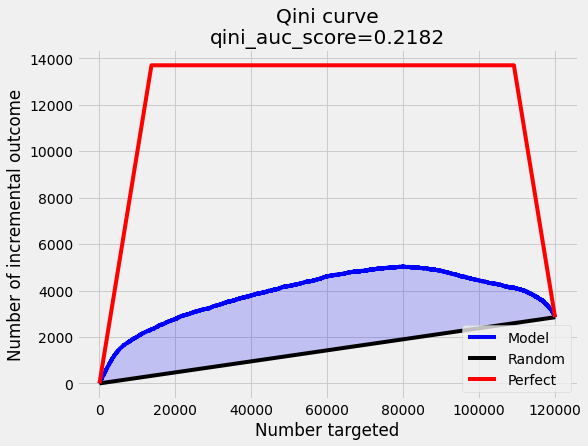

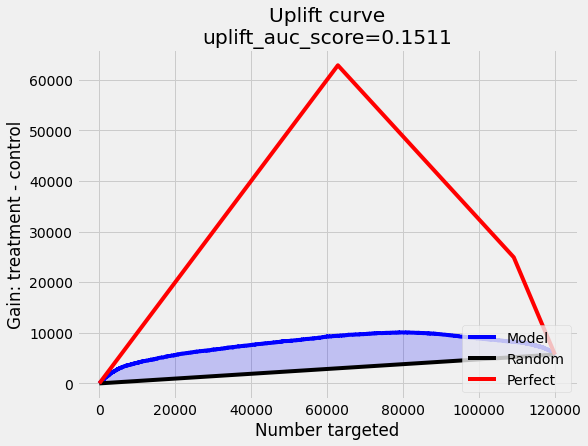

In [16]:
# import vizualisation tools
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
plot_qini_curve(y_true=y_val, uplift=uplift_tm_trmnt, treatment=treat_val, negative_effect=True)

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_tm_trmnt, treat_val, perfect=True);

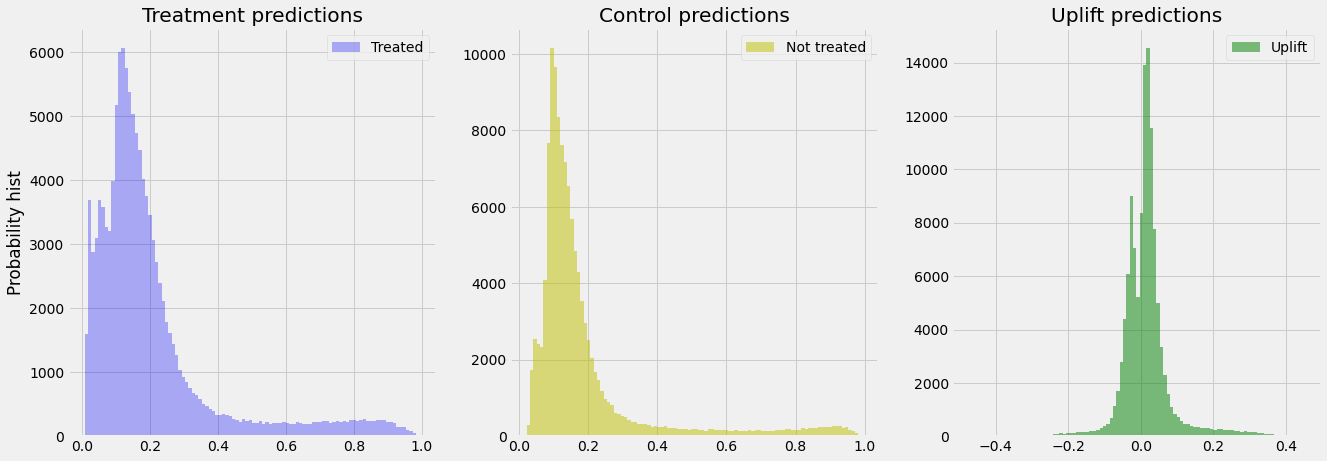

In [18]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

model_1 = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

models_1 = Pipeline(steps=[('t', PolynomialFeatures(degree=2)), ('m', model_1)])


sm = SoloModel(models_1)
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

sm_trmnt_preds = sm.trmnt_preds_

sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

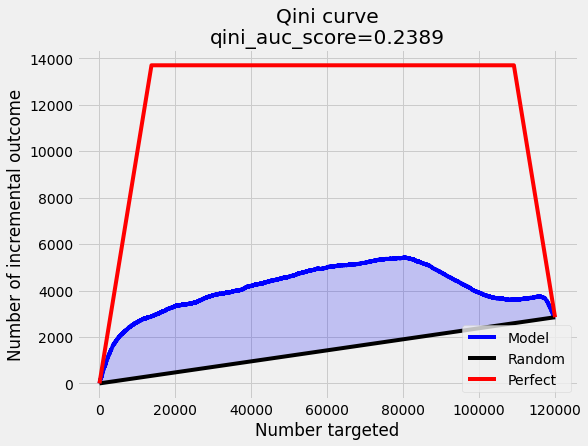

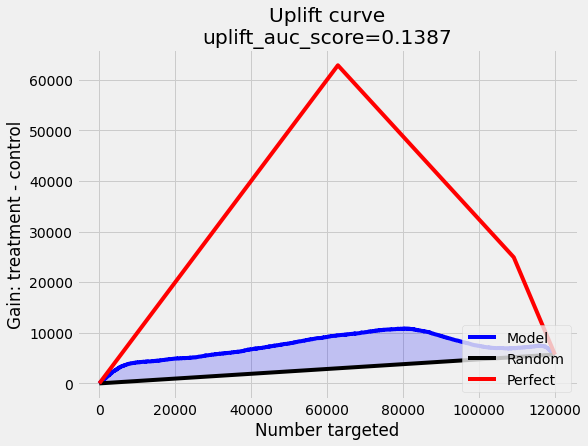

In [19]:
# import vizualisation tools
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
plot_qini_curve(y_true=y_val, uplift=uplift_sm, treatment=treat_val, negative_effect=True)

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=True);

In [21]:
from sklift.models import ClassTransformation


ct = ClassTransformation(lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-21-85c05811d5a8>:6: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


### Лучший метод

In [23]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
4,ClassTransformation,0.304570
3,SoloModel,0.209031
0,TwoModels,0.203372
2,TwoModels_ddr_treatment,0.200992
1,TwoModels_ddr_control,0.194213


### Построим uplift модель, использую Pylift 🙈🙈

In [63]:

up1 = TransformedOutcome(df_train,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=df_train['Treatment'],
                         test_size=0.2,
                         continuous_outcome=False
                        )

# up1.randomized_search(
#     param_distributions={
#         'max_depth': range(5,21),
#         'min_samples_split': range(500,7500),
#         'n_estimators': range(3,200)
#     },
#     n_iter=300,
#     cv=5,
#     n_jobs=-1
# )
# up1.fit(**up1.rand_search_.best_params_)
# up1.rand_search_.best_params_


best_params = {
    'n_estimators': 22,
    'min_samples_split': 6079,
    'max_depth': 7
}

up1.fit(**best_params)

[19:58:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




### Оценим uplift  модели

Qini AUC: 0.05450
Qini AUC: 0.03784


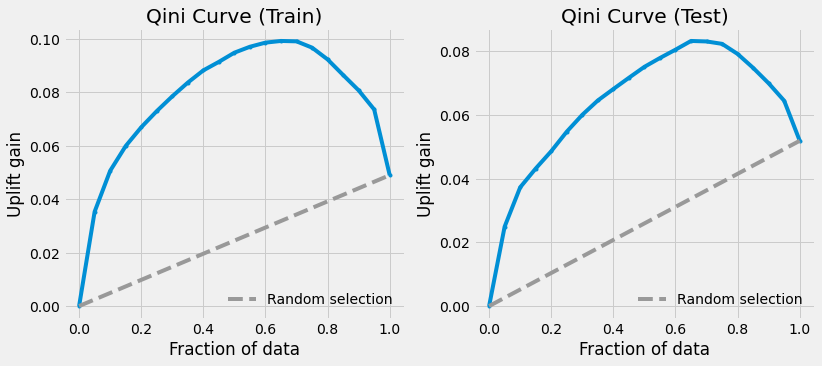

In [67]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up1.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

print("Qini AUC: {:.5f}".format(up1.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up1.test_results_.Q_qini))

In [72]:
response_train_df = up1.df_train[up1.df_train.Treatment==1].copy()
response_test_df = up1.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    lgb.LGBMClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]


In [73]:
# Для тестовых данных построим на uplift/response scores
results_df = up1.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up1.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

results_df.head()

,Treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_47,X_48,X_49,X_50,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
575850,0,-127.858410,1.213700,39.414897,22.397456,-20.421532,-28.083485,76.878406,-79.608868,16.953369,...,-841.358300,-120.349034,-9.080413,-36.745483,0,-0.0,0.235970,0.231879,"(0.23, 0.236]","(0.164, 1.503]"
444417,1,-10.638012,-0.375161,25.836184,-53.102009,-54.685212,-259.182642,-78.113439,-113.459892,-41.528478,...,493.099673,96.173233,173.750326,5.194586,0,0.0,0.232862,0.086619,"(0.23, 0.236]","(0.0742, 0.094]"
55930,1,-10.186376,0.002557,28.449791,12.004977,-53.787347,281.102797,-27.777103,5.471789,53.489291,...,-433.626505,-44.109887,60.438110,-4.954865,0,0.0,0.220690,-0.019720,"(0.219, 0.222]","(-0.0485, 0.00976]"
114068,0,-24.760714,0.955257,22.758470,-37.877066,78.470238,-0.749662,30.133220,46.634188,-1.483082,...,389.503607,48.731620,-44.631490,-19.584424,0,-0.0,0.245399,0.076912,"(0.244, 0.256]","(0.0742, 0.094]"
547603,1,23.214425,-1.765240,12.000090,-42.611000,-10.723324,-153.027984,9.387889,-5.131639,30.963568,...,85.716853,30.122419,276.717912,-18.779063,1,1.99755,0.224039,0.015958,"(0.223, 0.225]","(0.00976, 0.0366]"


Сравнение частоты посещений между ответом и моделью поддержки
Comparison of visit rates between response and uplift model¶

In [75]:
def compute_visit_rates(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'

    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()

    treatment_visit_rates[targeting_strategy] = treatment_visit_rates[targeting_strategy].astype(str)
    control_visit_rates[targeting_strategy] = control_visit_rates[targeting_strategy].astype(str)

    treatment_visit_rates.columns = [targeting_strategy, 'visit_rate']
    control_visit_rates.columns = [targeting_strategy, 'visit_rate']

    return treatment_visit_rates, control_visit_rates

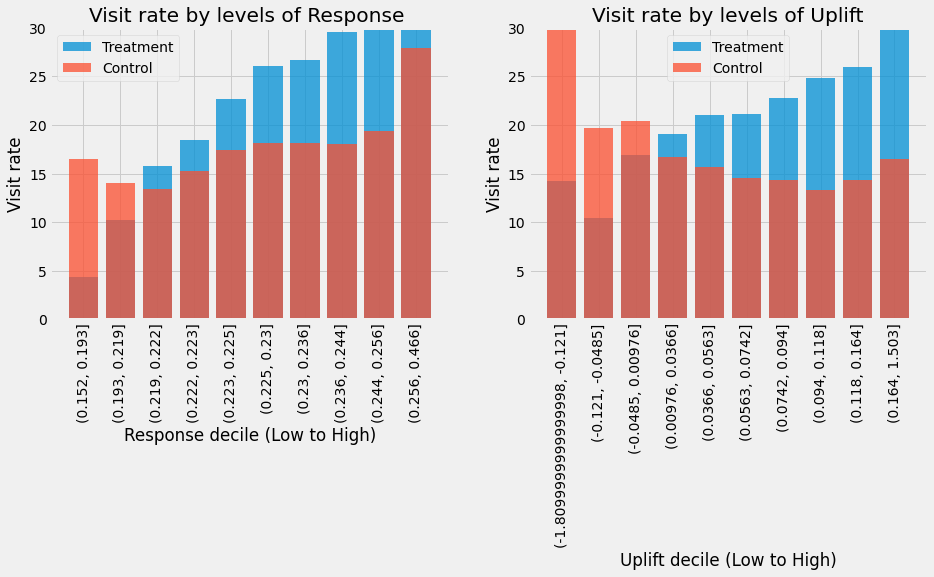

In [76]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

In [78]:
def compute_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100)
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100)

    treatment_effect = (treatment_visit_rates - control_visit_rates).reset_index()
    treatment_effect[targeting_strategy] = treatment_effect[targeting_strategy].astype(str)
    treatment_effect.columns = [targeting_strategy, 'treatment_effect']
    return treatment_effect

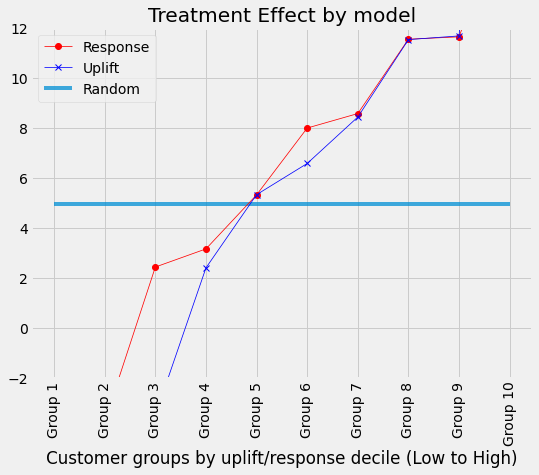

In [84]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect

In [88]:
def _compute_pooled_proportion(p1, n1, p2, n2):
    return ((p1 * n1) + (p2 * n2)) / (n1 + n2)


def _compute_se(p, n1, n2):
    return np.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))


def cumulative_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_group_visits = treatment_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    treatment_group_visits['total'] = treatment_group.groupby(targeting_strategy)['Outcome'].count().values
    control_group_visits = control_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    control_group_visits['total'] = control_group.groupby(targeting_strategy)['Outcome'].count().values

    treatment_group_visits[targeting_strategy] = treatment_group_visits[targeting_strategy].astype(str)
    control_group_visits[targeting_strategy] = control_group_visits[targeting_strategy].astype(str)

    treatment_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']
    control_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']

    # Highest to Lowest decile groups
    treatment_group_visits, control_group_visits = treatment_group_visits.iloc[::-1], control_group_visits.iloc[::-1]

    treatment_group_visits['visits_cumul'] = treatment_group_visits['num_website_visits'].cumsum()
    treatment_group_visits['total_visits_cumul'] = treatment_group_visits['total_website_visits'].cumsum()
    treatment_group_visits['cumul_visit_rate'] = treatment_group_visits['visits_cumul'] / treatment_group_visits[
        'total_visits_cumul']
    control_group_visits['visits_cumul'] = control_group_visits['num_website_visits'].cumsum()
    control_group_visits['total_visits_cumul'] = control_group_visits['total_website_visits'].cumsum()
    control_group_visits['cumul_visit_rate'] = control_group_visits['visits_cumul'] / control_group_visits[
        'total_visits_cumul']

    treatment_effects = treatment_group_visits['cumul_visit_rate'].to_frame().copy().rename(columns={
        'cumul_visit_rate': 'treatment_cumul_visit_rate'})
    treatment_effects['control_cumul_visit_rate'] = control_group_visits['cumul_visit_rate']
    treatment_effects['cumul_treatment_effect'] = (treatment_group_visits['cumul_visit_rate'] - control_group_visits[
        'cumul_visit_rate'])
    p1, p2 = treatment_group_visits['cumul_visit_rate'], control_group_visits['cumul_visit_rate']
    n1, n2 = treatment_group_visits['total_visits_cumul'], control_group_visits['total_visits_cumul']
    treatment_effects['pooled_proportion'] = _compute_pooled_proportion(p1, n1, p2, n2)
    treatment_effects['standard_error'] = _compute_se(treatment_effects['pooled_proportion'].values, n1, n2)

    return treatment_effects.reset_index(drop=True)

In [101]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)
uplift_cumul_treatment_effect

,treatment_cumul_visit_rate,control_cumul_visit_rate,cumul_treatment_effect,pooled_proportion,standard_error
0,0.535857,0.164826,0.371031,0.351083,0.008714
1,0.398615,0.153961,0.244653,0.276125,0.005772
2,0.348481,0.146987,0.201494,0.247611,0.004550
3,0.318543,0.146223,0.172320,0.232146,0.003854
4,0.296801,0.146082,0.150719,0.221467,0.003390
5,0.282328,0.147897,0.134431,0.215167,0.003063
6,0.269242,0.150656,0.118586,0.210048,0.002811
7,0.256869,0.157425,0.099443,0.207156,0.002616
8,0.239799,0.161845,0.077954,0.200852,0.002438
9,0.230050,0.178120,0.051930,0.204117,0.002327


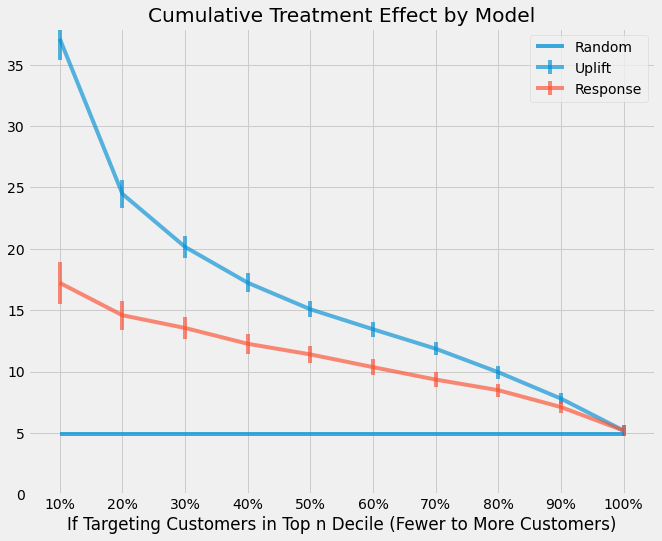

In [102]:
response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(10,8))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Response',
    alpha=0.65
)

plt.ylim(0,38)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

In [103]:
results_df['uplift_decile'].value_counts().sort_index(ascending=False).reset_index().\
rename(columns={'uplift_decile': 'number_of_customers', 'index': 'uplift_decile'})

,uplift_decile,number_of_customers
0,"(0.164, 1.503]",12000
1,"(0.118, 0.164]",12000
2,"(0.094, 0.118]",12000
3,"(0.0742, 0.094]",12000
4,"(0.0563, 0.0742]",12000
5,"(0.0366, 0.0563]",12000
6,"(0.00976, 0.0366]",12000
7,"(-0.0485, 0.00976]",12000
8,"(-0.121, -0.0485]",12000
9,"(-1.8099999999999998, -0.121]",12000


In [112]:
list(df_train.columns[1:10])

['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9']

Features: ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9']


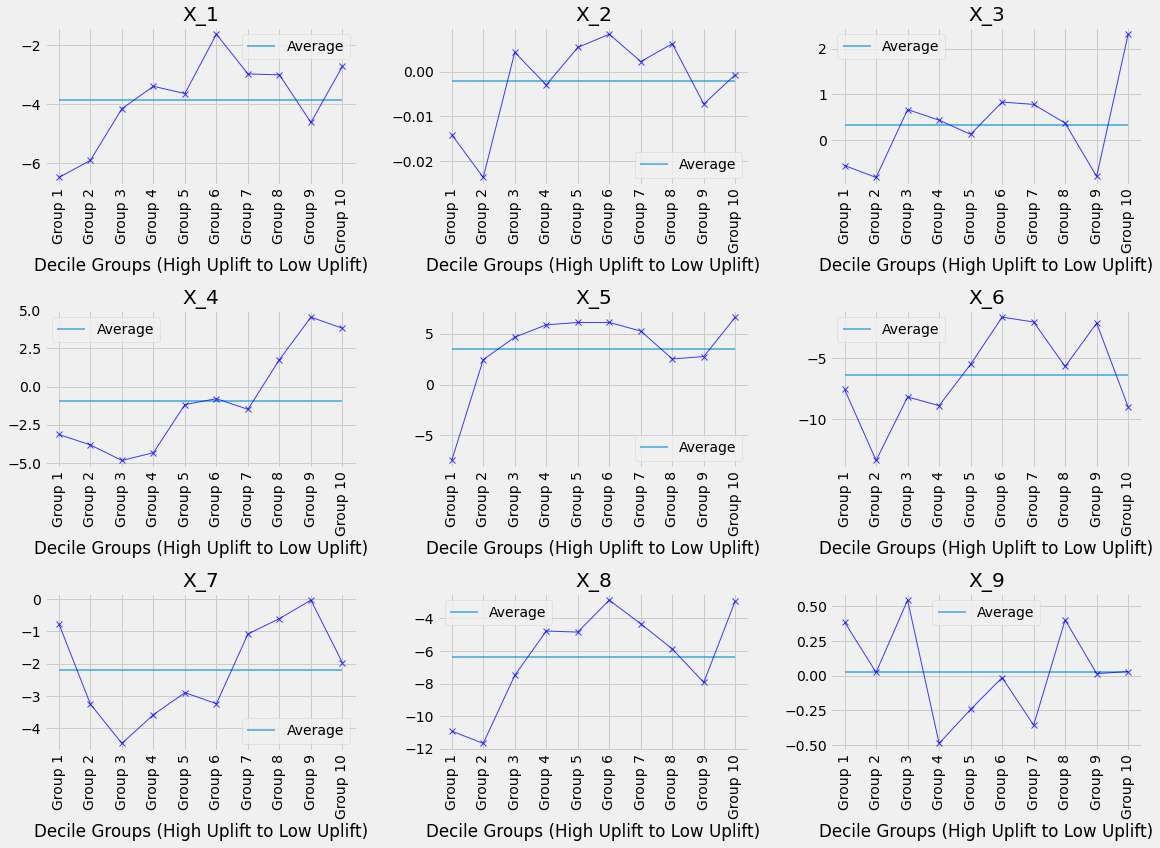

In [116]:
feats = df_train.columns[1:10]
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

print(f"Features: {list(df_train.columns[1:10])}")

fig = plt.figure(figsize=(16,12))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(3,3,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout() 

### После проверки всех линейных/нелинейных моделей я решил обучить нейронную сеть ❤❤❤
сразу привожу вариант с лучшими параметрами

In [25]:
def recall(y_true, y_pred):
    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + tf.keras.backend.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())

    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + tf.keras.backend.epsilon())

    return 2*((precision*recall)/(precision + recall + tf.keras.backend.epsilon()))

    

Epoch 1/5
48000/48000 [==============================] - 43s 895us/step - loss: 0.4337 - f1_score: 0.1374 - accuracy: 0.8414
Epoch 2/5
48000/48000 [==============================] - 43s 900us/step - loss: 0.4366 - f1_score: 0.1566 - accuracy: 0.8503
Epoch 3/5
48000/48000 [==============================] - 41s 848us/step - loss: 0.4638 - f1_score: 0.1548 - accuracy: 0.8491
Epoch 4/5
48000/48000 [==============================] - 40s 843us/step - loss: 0.4989 - f1_score: 0.1498 - accuracy: 0.8467
Epoch 5/5
12000/12000 [==============================] - 5s 411us/step
0.45854599870594676


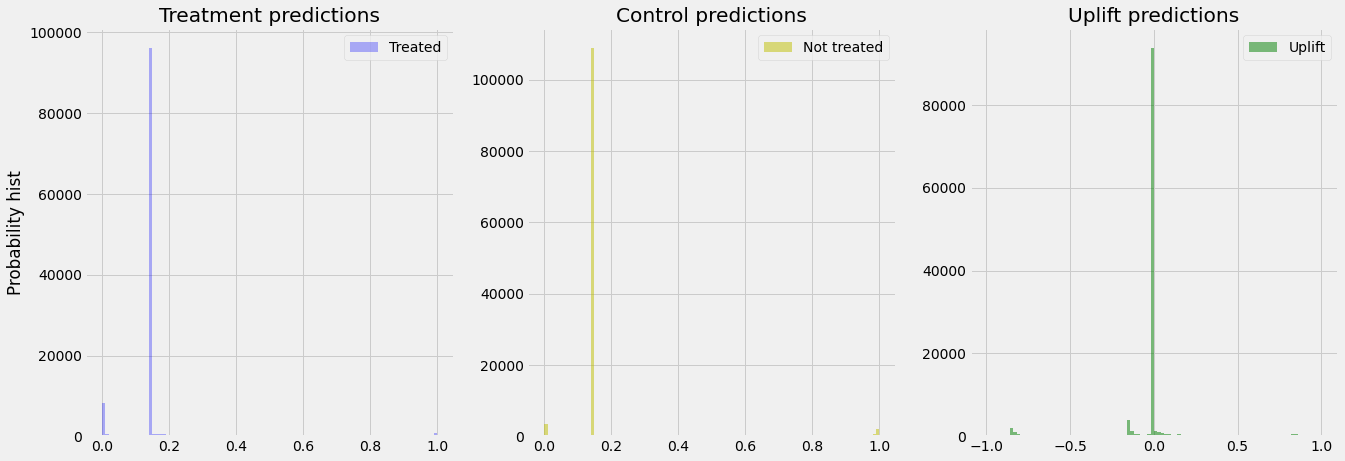

In [28]:
from sklift.models import TwoModels


def create_smaller():
    model = keras.Sequential()
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(52, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='uniform'))
    model.compile(loss='binary_crossentropy', metrics=[f1_score, 'accuracy']) 
    
    return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=5, batch_size=10, verbose=True)))

# define the grid search parameters
#batch_size = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#epochs = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#weight_constraint = [1, 3, 5]

#param_grid = dict(mlp__epochs=epochs)
#grid = GridSearchCV(estimator=Pipeline(estimators), param_grid=param_grid, n_jobs=3, cv=3, verbose=10)

sm = SoloModel(Pipeline(estimators))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

sm_trmnt_preds = sm.trmnt_preds_

sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

print(qini_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val))


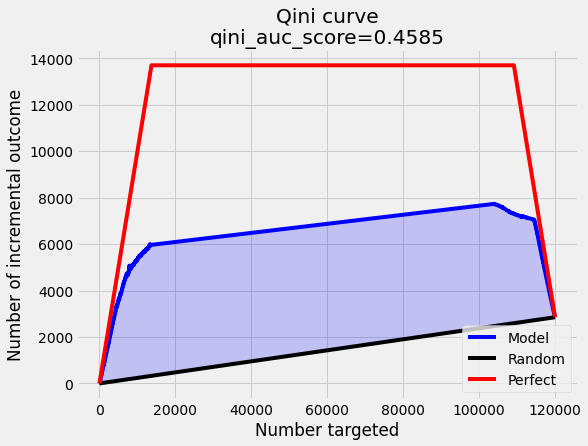

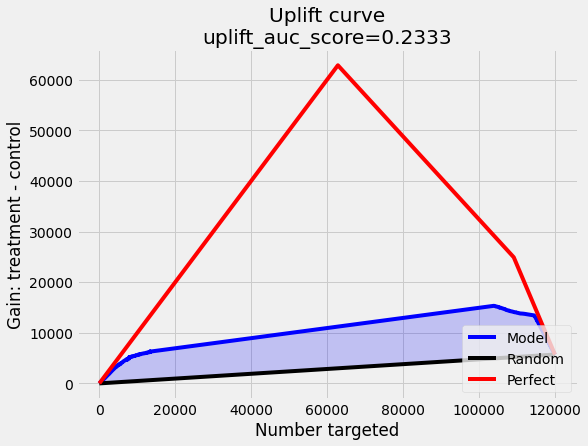

In [29]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
plot_qini_curve(y_true=y_val, uplift=uplift_sm, treatment=treat_val, negative_effect=True)

plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=True);